Cell Nuclei Separation — Watershed
Task: Separate touching nuclei.

Methods: Marker-controlled watershed.

Dataset: Kaggle — Data Science Bowl Cell Nuclei.

Compare: With vs. without markers.

Learning: Over-segmentation control.

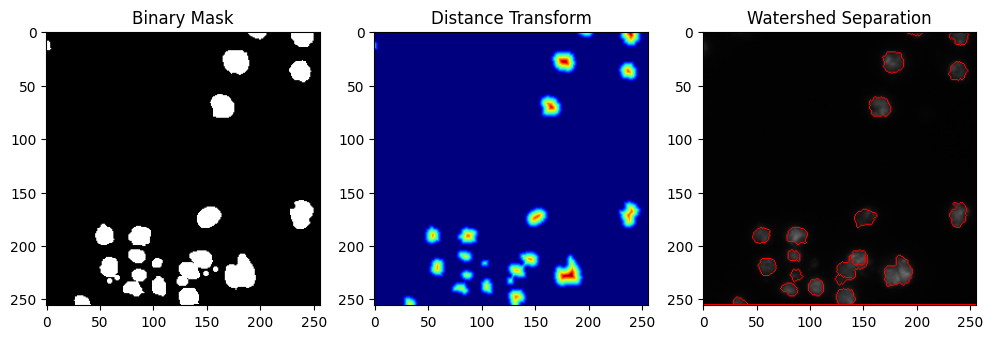

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# path to dataset
train_path = "dataset/stage1_train"

# pick one sample folder
sample_id = os.listdir(train_path)[0]

img_path = os.path.join(train_path, sample_id, "images", sample_id + ".png")
mask_dir = os.path.join(train_path, sample_id, "masks")

# read image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# combine all masks
mask = np.zeros(img.shape[:2], dtype=np.uint8)

for m in os.listdir(mask_dir):
    m_img = cv2.imread(os.path.join(mask_dir, m), 0)
    mask = np.maximum(mask, m_img)

# threshold mask
_, binary = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)

# noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# sure background
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# distance transform
dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

# sure foreground
_, sure_fg = cv2.threshold(dist, 0.4*dist.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# unknown region
unknown = cv2.subtract(sure_bg, sure_fg)

# markers
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown==255] = 0

# watershed
markers = cv2.watershed(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), markers)

# boundary marked in red
result = img.copy()
result[markers == -1] = [255,0,0]

# show results
plt.figure(figsize=(12,6))

plt.subplot(1,3,1)
plt.title("Binary Mask")
plt.imshow(binary, cmap='gray')

plt.subplot(1,3,2)
plt.title("Distance Transform")
plt.imshow(dist, cmap='jet')

plt.subplot(1,3,3)
plt.title("Watershed Separation")
plt.imshow(result)

plt.show()